# Class 9

## Mar. 12, 2024

By the end of this class, you'll be able to:

- Obtain bootstrap confidence intervals;

- Compare two samples using shuffling and bootstrapped resampling;

- Learn linear regression

## Arrangment of the last 3 tutorials

- You will think about and start to do your course projects in tutorials.

- Take the chance to discuss with your colleagues and TA!

# Bootstrap - start with a story

- A data scientist is using the data in a random sample to estimate an unknown statistical parameter such as the mean time spent resting. She uses the sample to calculate the value of a statistic that she will use as her estimate.

- Once she has calculated the observed value of her statistic, she could just present it as her estimate and go on her merry way. But she’s a data scientist. She knows that her random sample is just one of numerous possible random samples, and thus her estimate is just one of numerous plausible estimates.

- By how much could those estimates vary? To answer this, it appears as though she needs to draw another sample from the population, and compute a new estimate based on the new sample. But she doesn’t have the resources to go back to the population and draw another sample.

- It looks as though the data scientist is stuck.

- Fortunately, a brilliant idea called the bootstrap can help her out. Since it is not feasible to generate new samples from the population, the bootstrap generates new random samples by a method called resampling: the new samples are drawn at random from the original sample.

- We observed before that a large random sample from a population resembles the population from which it was drawn.

In [192]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns


time_use_df = pd.read_csv('gss_tu2016_main_file.csv')

```
dur01              Duration - Sleeping, resting, relaxing, sick in bed

           VALUE  LABEL
               0  No time spent doing this activity
            9996  Valid skip
            9997  Don't know
            9998  Refusal
            9999  Not stated

           Data type: numeric
           Missing-data codes: 9996-9999
           Record/columns: 1/65-68
```



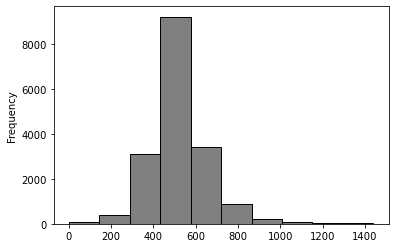

In [193]:
time_use_df['dur01'].plot.hist(color = 'grey', edgecolor = 'black');

In [194]:
print(time_use_df['dur01'].median())
print(time_use_df['dur01'].mean())

510.0
522.3930994824611


- Draw a random sample ***with replacement*** of the same size (number of rows) as the original sample.

- This opens the possibility for the new sample to be different from the original sample.

510.0
520.5645773433007


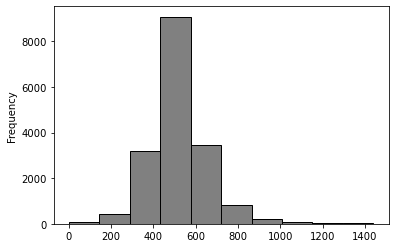

In [195]:
sleep_bs_sample = time_use_df['dur01'].sample(frac = 1, replace=True)

sleep_bs_sample.plot.hist(color = 'grey', edgecolor = 'black');

print(sleep_bs_sample.median())
print(sleep_bs_sample.mean())

## Why is this a good idea?

- By the law of averages, if we have many resamples, the distribution of all the resamples should close to the distribution of the "true" distribution (i.e., the population distribution)

- Make it clear: by bootstrap, we can obtain a distribution of certain statstics (e.g., mean), instead of a single value

## Resampled mean

- We generated one resampled or *bootstrapped* mean above.

- By resampling many times we can compute the empirical distribution of the mean sleep time.

- The distribution of the boostrapped means should contain the population mean.

In [196]:
def one_bs_mean():
    mean_bsample = time_use_df['dur01'].sample(frac = 1, replace=True).mean()
    return mean_bsample

one_bs_mean()

522.7950546290972

- Now let's compute many resampled mean by writing a `for` loop.

In [197]:
bootstrap_means = []  # empty list to collect means

for _ in range(5000):
    bootstrap_means.append(one_bs_mean())

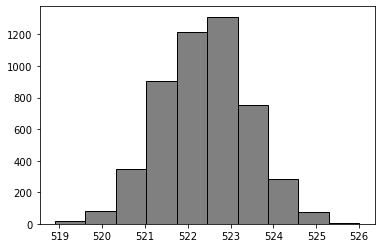

In [198]:
plt.hist(bootstrap_means, color = 'grey', edgecolor = 'black');

## Boostrap confidence intervals (CIs)

- We can use the bootstrap distribution to construct a range of values such that 95% of the random samples will contain the true mean (i.e., population mean).

- The range of values is called a confidence interval.

- A 95% confidence interval for the mean can be constructed finding the 2.5% percentile and the 97.5% percentile.  

- The reason for choosing 2.5% and 97.5% is that 0.05/2 = 0.025, and 1 - 0.025 = 0.975.   

- We can do this using the `percentile` function in `numpy`.

In [199]:
low_range = np.percentile(bootstrap_means, 2.5)
high_range = np.percentile(bootstrap_means, 97.5)
print(f"A 95% bootstrap confidence interval for mean is {round(low_range,2)} minutes to {round(high_range,2)} minutes.")

A 95% bootstrap confidence interval for mean is 520.44 minutes to 524.4 minutes.


## Using Bootstrap confidence intervals to compare samples

### Do people with no children under 14 spend more time resting? 

- Let's create a dataset (`DataFrame`) with children under 14 and time spent resting.

```
chh0014c           Child(ren) in household - 0 to 14 years

           VALUE  LABEL
               0  None
               1  One
               2  Two
               3  Three or more
               6  Valid skip
               7  Don't know
               8  Refusal
               9  Not stated

```

In [200]:
cols = ['dur01', 'chh0014c']

colnames = {cols[0] : 'resttime',
            cols[1] : 'children'}

restchild_df = time_use_df[cols]

restchild_df = restchild_df.copy()

restchild_df.rename(columns = colnames, inplace=True)

restchild_df.head()

,resttime,children
0,510,0
1,420,0
2,570,3
3,510,0
4,525,0


### Hypothesis testing

Two claims:

1. Null hypothesis: There is no difference in the average resting time between people with and without children under 14.  
2. Alternative hypothesis: There is difference in the average resting time between people with and without children under 14.
- 2a. Alternative hypothesis: People with children with children under 14 have less resting time than the people with no children under 14.

Create a new column `'Child_in_house'` that indicates if a child is in the house.

In [201]:
restchild_df.loc[restchild_df['children'] > 0, 'Child_in_house'] = 'Yes'

restchild_df.loc[restchild_df['children'] == 0, 'Child_in_house'] = 'No'

restchild_df.head()

,resttime,children,Child_in_house
0,510,0,No
1,420,0,No
2,570,3,Yes
3,510,0,No
4,525,0,No


In [202]:
mean_rest_times = restchild_df.groupby('Child_in_house')['resttime'].mean()

print(mean_rest_times)

print('Mean difference:', mean_rest_times[0] - mean_rest_times[1])

Child_in_house
No     525.826128
Yes    509.046936
Name: resttime, dtype: float64
Mean difference: 16.77919133837969


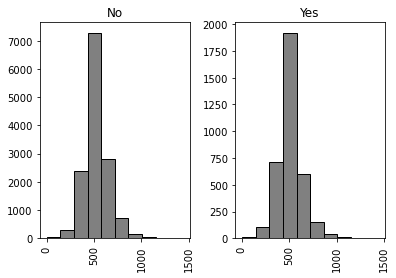

In [203]:
restchild_df[['Child_in_house', 'resttime']].hist(by = 'Child_in_house', bins = 10, edgecolor = 'black', color = 'grey');

Create a function to create one bootstrap sample of the mean difference.

In [204]:
child = restchild_df['Child_in_house'] == 'Yes'

nochild = restchild_df['Child_in_house'] == 'No'

def bs_one_mean_diff():
    # sample sleep and rest with replacement
    bssample = restchild_df.sample(frac = 1, replace =  True)
    
    # compute difference in means on bootstrap sample
    bs_mean_diff = (bssample.loc[nochild, 'resttime'].mean() - 
                   bssample.loc[child, 'resttime'].mean())
    return bs_mean_diff

bs_one_mean_diff()

14.183843323805775

- Compute bootstrap distribution. 

In [205]:
bootst_mean_diffs = []

for _ in range(5000):
    bootst_mean_diffs.append(bs_one_mean_diff())

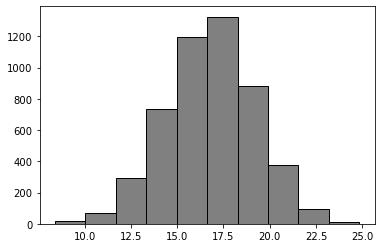

In [206]:
plt.hist(bootst_mean_diffs, color = 'grey', edgecolor = 'black');

A 95% confidence interval for the mean difference is:

In [207]:
np.percentile(bootst_mean_diffs, 2.5), np.percentile(bootst_mean_diffs, 97.5) 

(12.076536619242049, 21.439307929666562)

The confidence interval does not contain 0 and larger than 0.
- The null hypothesis is rejected; the alternative hypothesis is accepted (in 95% CI).
- The people without children have significantly more resting time than the people with children in 95% CI. 

## In-class exercise

Modify the code above to compute a 95% bootstrap confidence interval for the difference in 90th percentiles between respondents with and without children under 14.  Does the confidence interval contain 0?

In [208]:
np.percentile(bootst_mean_diffs, 5), np.percentile(bootst_mean_diffs, 95) 

(12.748715742641815, 20.7058104123397)

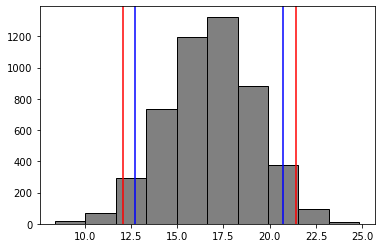

In [209]:
plt.hist(bootst_mean_diffs, color = 'grey', edgecolor = 'black')
# 95% confidence intervel in red line
plt.axvline(x = np.percentile(bootst_mean_diffs, 2.5), color = 'r', label = 'axvline - full height')
plt.axvline(x = np.percentile(bootst_mean_diffs, 97.5), color = 'r', label = 'axvline - full height')
# 90% confidence intervel in blue line
plt.axvline(x = np.percentile(bootst_mean_diffs, 5), color = 'b', label = 'axvline - full height')
plt.axvline(x = np.percentile(bootst_mean_diffs, 95), color = 'b', label = 'axvline - full height');


Larger confidence interval (95% v.s. 90%) mean wider distribution 
- Less likely (5% v.s. 10%) to be wrong to reject the null hypothesis

### Another method to compare two samples (A review of shuffling)

### Hypothesis testing

Two claims:

1. Null hypothesis: The average resting time of people with children is the same as the average resting time of people without children.
2. Alternative hypothesis: The average resting time of people with children is different from the average resting time of people without children.
- 2a. Alternative hypothesis: People with children with children under 14 have less resting time than the people with no children under 14.

#### A thought expriement: shuffling process


- Imagine we have `len(restchild_df.loc[child])` cards labelled `Child` and `len(restchild_df.loc[nochild])` cards labelled `No_child`.


- Shuffle the cards ...


- Assign the cards to the samples then calculate the mean resting time difference between `Child` and `No_child`.  This is one simulated value of the test statistic. 


- Shuffle the cards again ...


- Assign the cards to the samples then calculate the mean resting time difference between `Child` and `No_child`. This is second simulated value of the test statistic. 


- Continue shuffling, assigning , and computing the mean difference... in many times

If there is no differences of the average rest time between people with or without children (null hypothesis), the shuffling process will change the mean difference. In other words, we will observe many 'unusual' mean differences.

In [210]:
restchild_df.head()

,resttime,children,Child_in_house
0,510,0,No
1,420,0,No
2,570,3,Yes
3,510,0,No
4,525,0,No


#### Step 1: shuffling the children label and assignment to the samples

In [211]:
shuffle_df = restchild_df.copy()
restchild_sim = shuffle_df['Child_in_house'].sample(frac=1, replace = False).reset_index(drop = True)
restchild_sim.head()

0     No
1     No
2     No
3    Yes
4     No
Name: Child_in_house, dtype: object

#### Step 2: compute the mean resting time difference between people with and without children

In [212]:
mean_child = shuffle_df.loc[restchild_sim == 'Yes', 'resttime'].mean()
mean_nochild = shuffle_df.loc[restchild_sim == 'No', 'resttime'].mean()

sim_diff = mean_nochild - mean_child
sim_diff

-0.6287392010965505

#### Step 3: Repeat Steps 1 and 2 a large number of times (e.g., 5000) to get the distribution of mean differences. 

In [213]:
simulated_diffs = []

for _ in range(5000):
    restchild_sim = shuffle_df['Child_in_house'].sample(frac=1, replace = False).reset_index(drop = True)
    mean_child = shuffle_df.loc[restchild_sim == 'Yes', 'resttime'].mean()
    mean_nochild = shuffle_df.loc[restchild_sim == 'No', 'resttime'].mean()
    sim_diff = mean_nochild - mean_child
    simulated_diffs.append(sim_diff)

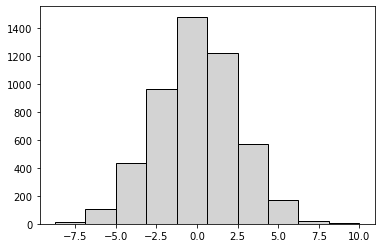

In [214]:
import matplotlib.pyplot as plt

plt.hist(simulated_diffs, edgecolor = 'black', color = 'lightgrey');

#### Step 4: Compare the simulate mean differences to the observed mean difference and calculate p-value

In [215]:
obs_mean_nochild = restchild_df.loc[restchild_df['Child_in_house']=='No', 'resttime'].mean()
obs_mean_child = restchild_df.loc[restchild_df['Child_in_house']=='Yes', 'resttime'].mean()

obs_diff = obs_mean_nochild - obs_mean_child
obs_diff

16.77919133837969

In [216]:
simulated_diffs_df = pd.DataFrame({'sim_diffs' : simulated_diffs})

numgreater = (simulated_diffs_df['sim_diffs'] >= obs_diff).sum()
print('The number of simulated differences greater than the observed difference is:', numgreater)

numsmaller = (simulated_diffs_df['sim_diffs'] <= -1 * obs_diff).sum()
print('The number of simulated differences smaller than the observed difference is:', numsmaller)

pvalue = (numgreater + numsmaller)/ 5000

print('The p-value is:', pvalue)

The number of simulated differences greater than the observed difference is: 0
The number of simulated differences smaller than the observed difference is: 0
The p-value is: 0.0


#### Step 5: Interpretation

None of the simulated differences is greater or smaller than the observed differences.
- The null hypothesis is rejected.

The observed differences of resting time between people with and without children are true difference (instead of random error).
- obs_diff > 0, indicating people without children have more restting time.  

# Think about: 

# what is the difference between bootstrap and shuffling?


1. Both bootstrap and shuffling can be applied to compare two samples, but their logics are different.
- Bootstrap: resampling **with displacement** and get the distribution of mean differences, which represents the mean differences in population

```bssample = restchild_df.sample(frac = 1, replace =  True)```

- Shuffling: shuffle the label (reampling **without displacement**) and reassign to the samples to get the distribution of mean differences, which represents the "unusual" values

```restchild_sim = shuffle_df['Child_in_house'].sample(frac=1, replace = False).reset_index(drop = True) ```

2. Bootstrap can be applied to many other situations in order to obtain robust results (e.g., regression), while shuffling can only applied in comparison between samples.


# Linear Regression

## Basic idea

- Linear regression is a useful technique for creating models to explain (linear) relationships between variables. 

- For use in multiple regression variables the dependent variable must be numeric, and have meaningful numeric values (i.e., must be an interval variable).


- The independent variables can be categorical or interval variables.

## Example 1: perfect linear relationship between dependent and independent variables

### Data

In [217]:
import pandas as pd
import numpy as np

data = {'depvar' : np.arange(start = 0, stop = 8, step =1),
       'indvar' : np.arange(start = 0, stop = 8, step =1)}

df = pd.DataFrame(data)

df

,depvar,indvar
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7


### Plot the data

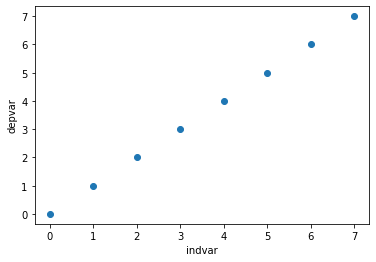

In [218]:
import matplotlib.pyplot as plt

plt.scatter(x = df['indvar'], y = df['depvar'])
plt.xlabel('indvar')
plt.ylabel('depvar');

- The scatter plot shows each pair of points (1, 1), (2, 2), etc. 

- `'indvar'` is sometimes called a predictor variable or covariate, and `'depvar'` is called the dependent variable.

- The dependent variable is predicted exactly by the independent variable.

### Compute the regression line

In [219]:
from statsmodels.formula.api import ols

regmod = ols('depvar ~ indvar', data = df) # setup the model

- The code above uses the `ols` function from [`statsmodels.formula.api`](https://www.statsmodels.org/stable/api.html#statsmodels-formula-api)

- The syntax in the function `ols` function `'depvar ~ indvar'` is a special syntax for describing statistical models.  

- The column name to the **left** of `~` specifies the dependent variable.

- The column name to the **right** of `~` specifies the independent variable(s).

In [220]:
regmod_fit = regmod.fit() # estimate/fit the model 

After the model is setup then the `fit` function can be applied to the model.  This function computes the equation of the regression line.

In [221]:
regmod_fit.params # get parameter estimates

Intercept    5.551115e-16
indvar       1.000000e+00
dtype: float64

- The estimates of the **y-intercept** and **slope** are labelled `Intercept` (1.11e-16 approx 0)  and `indvar` (1.00e+00 approx 1).

- This means the regression equation is: $$\texttt{depvar} = 0 + 1 \times \texttt{indvar}$$

## Example 2: another perfect linear relationship

In [222]:
data = {'depvar' : np.arange(start = 0, stop = 8, step =1) + 2,
       'indvar' : np.arange(start = 0, stop = 8, step =1)}

df = pd.DataFrame(data)

df

,depvar,indvar
0,2,0
1,3,1
2,4,2
3,5,3
4,6,4
5,7,5
6,8,6
7,9,7


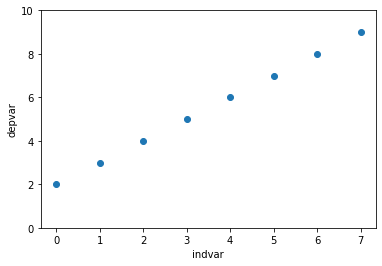

In [223]:
plt.scatter(x = df['indvar'], y = df['depvar'])
plt.ylim([0, 10])
plt.xlabel('indvar')
plt.ylabel('depvar');

In [224]:
regmod = ols('depvar ~ indvar', data = df) # setup the model

regmod_fit = regmod.fit() # estimate/fit the model 

regmod_fit.params # get parameter estimates

Intercept    2.0
indvar       1.0
dtype: float64

- The scatter plot is similar to Example 1 except that the values of the dependent variable has been increased by 2.

- The equation of the regression line for this data is:  $$\texttt{depvar} = 2 + 1 \times \texttt{indvar} $$

### Interpretation of y-intercept

- When the independent variable is 0 the dependent variable is 2.  This is the meaning of the **y-intercept** value of 2.

### Interpretation of slope

- For a one-unit change in the independent variable the dependent variable changes by 1 unit.

## Example 3: close to linear

- Examples 1 and 2 were perfect linear relationships.

- In this example we examine what happens if the relationship between the dependent and independent variables is almost linear.

In [225]:
np.random.seed(11) #set the seed so that it's reproducible

data = {'depvar' : np.arange(start = 0, stop = 8, step =1) + 2,
        'indvar' : np.arange(start = 0, stop = 8, step =1) + np.random.uniform(low = 0, high = 2, size = 8)}

df = pd.DataFrame(data)

df

,depvar,indvar
0,2,0.360539
1,3,1.038950
2,4,2.926437
3,5,4.449868
4,6,4.840407
5,7,5.970854
6,8,6.025562
7,9,7.974743


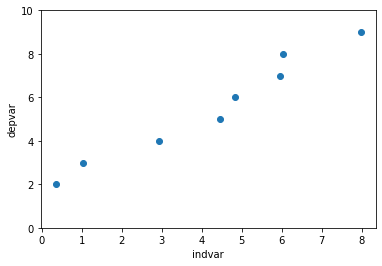

In [226]:
plt.scatter(x = df['indvar'], y = df['depvar'])
plt.ylim([0, 10])
plt.xlabel('indvar')
plt.ylabel('depvar');

In [227]:
regmod = ols('depvar ~ indvar', data = df) # setup the model

regmod_fit = regmod.fit() # estimate/fit the model 

regmod_fit.params # get parameter estimates

Intercept    1.625418
indvar       0.922867
dtype: float64

So, now the relationship isn't perfectly linear, but close.  The equation of this regression line is:

$$\texttt{depvar} = 1.63 + 0.92 \times \texttt{indvar}$$

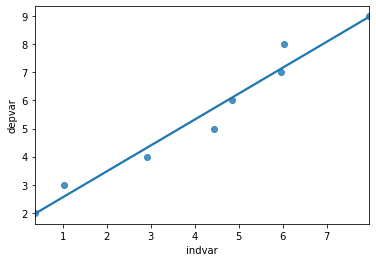

In [228]:
import seaborn as sns

sns.regplot(x = 'indvar', y = 'depvar', data = df, ci = None);

The `regplot` function in the `seaborn` library will produce a scatter plot with the regression line.

The parameters of `regplot`

- `x` is the independent variable.
- `y` is the dependent variable.
- `ci = None` specifies no confidence interval for the regression line 

### Statistical summary of linear regression

In [229]:
import warnings
warnings.filterwarnings('ignore') # turn off warnings

regsum = regmod_fit.summary()
regsum.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6254,0.353,4.607,0.004,0.762,2.489
indvar,0.9229,0.073,12.700,0.000,0.745,1.101


- A statistical summary of the regression model is given above using the `summary` function in `statsmodels`.

- There are three summary tables, but we will only be interested in the second summary table---`regsum.tables[1]` (in this course).

In [230]:
regsum.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6254,0.353,4.607,0.004,0.762,2.489
indvar,0.9229,0.073,12.700,0.000,0.745,1.101


What does the statistical summary represent?

- the column labelled `coef` are same values as `regmod_fit.params`.  In this case the average increase `depvar` for a one unit change in `indvar` is 0.9229.

- the `std err` column represents the standard deviation of the intercept and slope (we won't discuss in this course).

- the `t` column represents the value of the t-statistic (we won't discuss in this course).

In [231]:
regsum.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6254,0.353,4.607,0.004,0.762,2.489
indvar,0.9229,0.073,12.700,0.000,0.745,1.101


- the column `P>|t|` represents the p-value corresponding to the null hypothesis that the intercept or slope are equal to 0.  If the value is small then this is evidence against the null hypothesis.  But if the p-value is large then there is no evidence against the null hypothesis.  

- Currently, how small a p-value should be to provide evidence against a null hypothesis is being debated.  Although, the traditional threshold is 0.05 (i.e., a p-value less than or equal to 0.05 is supposed to indicate evidence against the null hypothesis).

- In the example above the p-value for the slope is 0.  This indicates strong evidence that the *true* value of the slope is non-zero.

- The columns `[0.025   0.975]` form a plausible range of values for the y-intercept and slope (formally known as a 95% confidence interval). In this case the plausible values for the slope are 0.745 and 1.101.  If the plausible range includes 0 then this is usually interpreted as not providing evidence against the null hypothesis.  

## Predicted values and residuals

If the values of the independent variable are plugged into the regression equation then we obtain the fitted values.

$$\texttt{depvar} = 1.63 + 0.92 \times \texttt{indvar}$$

In [232]:
df

,depvar,indvar
0,2,0.360539
1,3,1.038950
2,4,2.926437
3,5,4.449868
4,6,4.840407
5,7,5.970854
6,8,6.025562
7,9,7.974743


The fitted value for the first row of `df` is (when `indvar` == 0.360539) :

In [233]:
1.6254 + 0.9229*0.360539

1.9581414431

To extract the fitted values from a regression model use the `fittedvalues` function in `statsmodels`.

In [234]:
regmod_fit.fittedvalues

0    1.958148
1    2.584231
2    4.326129
3    5.732053
4    6.092469
5    7.135720
6    7.186208
7    8.985043
dtype: float64

- If the linear regression model is used on an independent variable that is not in the data set used to build the model then it's often referred to as a predicted value.

In [235]:
new_indvar = pd.DataFrame(data = {'indvar':[10,11,12,13]})
regmod_fit.predict(new_indvar['indvar'])

0    10.854085
1    11.776952
2    12.699818
3    13.622685
dtype: float64

The residual is the dependent variable minus the fitted value.

In [236]:
df.head(2)

,depvar,indvar
0,2,0.360539
1,3,1.038950


In [237]:
regmod_fit.fittedvalues.head(2)

0    1.958148
1    2.584231
dtype: float64

 So, for the first row the residual is:

In [238]:
2 - 1.9581414431

0.041858556900000066

To extract the residuals from a regression model use the `resid` function in `statsmodels`.

In [239]:
regmod_fit.resid

0    0.041852
1    0.415769
2   -0.326129
3   -0.732053
4   -0.092469
5   -0.135720
6    0.813792
7    0.014957
dtype: float64

- If the linear regression model fits the data well then the residuals should be close to 0.

- One indication that the linear regression model fits well is to examine the **diagnostic** scatter plot of residuals versus fitted values.

- **A plot that looks like a random scatter of points around 0 indicates that linear regression is an appropriate model.**

- Since there are only 8 points it's hard to spot a pattern.

Text(0, 0.5, 'residuals')

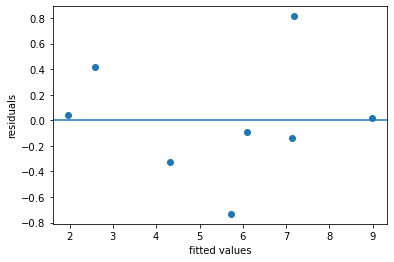

In [240]:
plt.scatter(regmod_fit.fittedvalues, regmod_fit.resid)
plt.axhline(y = 0)
plt.xlabel('fitted values')
plt.ylabel('residuals')

## Accuracy of linear regression

- There are several measures of accuracy for linear regression.

- One popular measure is R-squared, and root mean-squared error.

- R-squared can be calculated from a fitted model regression model using the `rsquared` function in `statsmodels`.

- R-squared is always between 0 and 1.  
     + R-squared of 0 indicates a poor fit
     + R-squared of 1 indicates a perfect fit

In [241]:
regmod_fit.rsquared

0.9641350308570086

## Example 4: regression with two or more independent variables

It's possible to include more than one independent variable in a regression model.  

In [242]:
np.random.seed(11) #set the seed so that it's reproducible

data = {'depvar' : np.arange(start = 0, stop = 8, step =1) + 2,
        'indvar1' : np.arange(start = 0, stop = 8, step =1) + np.random.uniform(low = 0, high = 2, size = 8),
        'indvar2' : np.arange(start = 0, stop = 8, step =1) + np.random.normal(loc = 0, scale = 1, size = 8)}

df = pd.DataFrame(data)

df

,depvar,indvar1,indvar2
0,2,0.360539,-0.536629
1,3,1.038950,1.315403
2,4,2.926437,2.421051
3,5,4.449868,1.934397
4,6,4.840407,3.113760
5,7,5.970854,4.524267
6,8,6.025562,6.689682
7,9,7.974743,7.561192


To include more than one independent variable in a regression model add it to the right side of syntax for describing statistical models.

`'depvar ~ indvar1 + indvar2'`

In [243]:
regmod = ols('depvar ~ indvar1 + indvar2', data = df) # setup the model

Now `fit` `regmod`.

In [244]:
regmod_fit = regmod.fit() # estimate/fit the model 

Extract the regression parameter estimates using `params`.

In [245]:
regmod_fit.params # get parameter estimates

Intercept    1.892482
indvar1      0.549341
indvar2      0.385197
dtype: float64

The estimated linear (multiple) linear regression model is:

$$\texttt{depvar} = 1.892482 + 0.549341 \times \texttt{indvar1} + 0.385197 \times \texttt{indvar2}$$

- The y-intercept value (1.892482) is the value of the dependent variable when `indvar1` and `indvar2` are both 0.

-  If `indvar1` changes by one-unit, `depvar` changes (on average) by 0.549341 (when `indvar2` remains the same).

-  If `indvar2` changes by one-unit, `depvar` changes (on average) by 0.385197 (when `indvar1` remains the same).

### Statistical summary of a multiple regression model

In [246]:
multregsummary = regmod_fit.summary()

multregsummary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8925,0.201,9.432,0.000,1.377,2.408
indvar1,0.5493,0.102,5.411,0.003,0.288,0.810
indvar2,0.3852,0.097,3.984,0.010,0.137,0.634


The statistical summary indicates:

- the p-value for `indvar1` is 0.003 and the range of plausible values for the slope is 0.288 to 0.810.

- the p-value for `indvar2` is 0.010 and the range of plausible values for the slope is 0.137 to 0.634.  

- Since, both p-values are small there is evidence that slope is different from 0, and the range of plausible values does not include 0.

### Accuracy of multiple regression model

In [247]:
regmod_fit.rsquared

0.991410032226906

Text(0, 0.5, 'residuals')

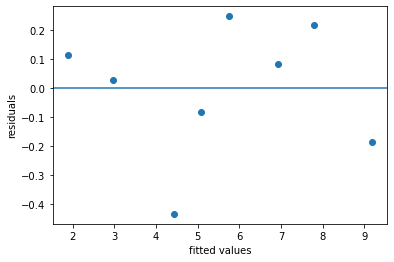

In [248]:
plt.scatter(regmod_fit.fittedvalues, regmod_fit.resid)
plt.axhline(y = 0)
plt.xlabel('fitted values')
plt.ylabel('residuals')

Questions?

## What is the effect of recent immigration on asthma rates in Toronto neighbourhoods?

### Data

- Data from <http://torontohealthprofiles.ca> contains data on asthma and immigration for each neighbourhood in Toronto.

#### Sociodemographic data

- Read sociodemographic data from the excel file `1_socdem_neighb_2006-2.xls` with sheet name `socdem_2006` into `pandas` using `read_excel`.


In [249]:
fname = '1_socdem_neighb_2006-2.xls'
sname = 'socdem_2006'
socdem_neighb = pd.read_excel(fname, sheet_name = sname, header = 10) # the table starts in row #10
socdem_neighb.head()

,Neighbourhood id,Neighbourhood Name,Total Population,% 19 and under,% 65 and over,% Living alone,% Aged 65+ living alone,% Lone parent families §,% 1 year mobility in population,Median household income before-tax $,...,% Less than high school education **,% With a University degree **,% No knowledge of English/French,% Recent immigrants-within 5 years,% Recent immigrants-within 10 years,% Immigrants,% Visible minority,"Top 3 Home Languages for non-English speaking households, #1","Top 3 Home Languages for non-English speaking households, #2","Top 3 Home Languages for non-English speaking households, #3"
0,1,West Humber-Clairville,32252,26.8,11.3,3.7,11.7,26.3,11.6,63413,...,18.4,22.9,5.4,12.2,22.1,60.0,77.9,Panjabi (Punjabi),Gujarati,Spanish
1,2,Mount Olive-Silverstone-Jamestown,32127,32.2,8.1,4.1,15.4,31.5,15.7,48146,...,20.1,23.6,7.6,22.2,35.1,67.1,85.3,Panjabi (Punjabi),Gujarati,Arabic
2,3,Thistletown-Beaumond Heights,9928,25.3,16.7,5.4,17.5,30.1,10.9,55032,...,16.7,20.7,5.0,9.7,19.3,55.9,53.8,Panjabi (Punjabi),Italian,Spanish
3,4,Rexdale-Kipling,10725,23.6,18.3,10.2,28.8,33.3,13.2,52428,...,15.3,18.8,3.0,8.3,14.0,47.2,41.8,Spanish,Panjabi (Punjabi),Croatian
4,5,Elms-Old Rexdale,9437,29.9,10.5,5.8,13.0,39.1,9.7,53779,...,15.2,18.8,3.6,9.8,18.2,53.8,60.5,Spanish,Italian,Urdu


Which column should we select to measure immigration?  There are several choices.

In [250]:
socdem_neighb.columns

Index(['Neighbourhood id', 'Neighbourhood Name', 'Total Population',
       '% 19 and under', '% 65 and over', '% Living alone',
       '% Aged 65+ living alone', '% Lone parent families §',
       '% 1 year mobility in population',
       'Median household income before-tax $',
       'Median household income after-tax $ ‡',
       '% Families-Incidence of low income before-tax',
       '% Families-Incidence of low income after-tax ‡',
       '% Individuals-Incidence of low income before-tax',
       '% Individuals-Incidence of low income after-tax ‡',
       '% Rented Dwellings', '% Unemployment rate *',
       '% Not in labour force *', '% Less than high school education **',
       '% With a University degree **', '% No knowledge of English/French',
       '% Recent immigrants-within 5 years',
       '% Recent immigrants-within 10 years', '% Immigrants',
       '% Visible minority',
       'Top 3 Home Languages for non-English speaking households, #1',
       'Top 3 Home Languages 

- Let's use `'% Recent immigrants-within 5 years'` to represent recent immigrants in a neighborhood.

- Later on we will want a few more sociodemographic columns, so let's create a new `DataFrame` and rename the columns.

In [251]:
cols = ['Neighbourhood id', 'Neighbourhood Name', 
        'Median household income after-tax $ ‡', 
        '% Rented Dwellings', '% Unemployment rate *', 
        '% Recent immigrants-within 5 years', '% Visible minority']

socdem_neighb = socdem_neighb[cols]

colnames = {cols[0] : 'Neighbid',
            cols[1] : 'name',
            cols[2] : 'median_income',
            cols[3] : 'rented_dwell',
            cols[4] : 'unemployment',
            cols[5] : 'immigration5',
            cols[6] : 'vismin'}

socdem_neighb = socdem_neighb.copy()

socdem_neighb.rename(columns = colnames, inplace = True)

In [252]:
socdem_neighb.head()

,Neighbid,name,median_income,rented_dwell,unemployment,immigration5,vismin
0,1,West Humber-Clairville,56220,27.4,7.0,12.2,77.9
1,2,Mount Olive-Silverstone-Jamestown,43975,52.0,9.9,22.2,85.3
2,3,Thistletown-Beaumond Heights,49800,34.4,6.3,9.7,53.8
3,4,Rexdale-Kipling,46033,45.1,7.7,8.3,41.8
4,5,Elms-Old Rexdale,48055,41.2,7.8,9.8,60.5


#### Asthma data

- Read data from the excel file `1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls` with sheet name `1_ahd_neighb_asthma_2007` into `pandas` using `read_excel`.

In [253]:
fname = '1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls'
sname = '1_ahd_neighb_asthma_2007'

asthma_neighb = pd.read_excel(fname, sheet_name = sname, header = 11) #the table starts with row #11
asthma_neighb.head()

,Unnamed: 0,Unnamed: 1,Demographics ª,% With asthma,LL (95% CI),UL (95% CI),Demographics ª.1,% With asthma.1,LL (95% CI) .1,UL (95% CI) .1,...,Demographics ª.7,% With asthma.7,LL (95% CI) .7,UL (95% CI) .7,Demographics ª.8,% With asthma.8,LL (95% CI) .8,UL (95% CI) .8,Rate Ratio**.2,H/L/NS.2
0,1,West Humber-Clairville,11977,9.7,9.2,10.2,11770,10.6,10.0,11.2,...,4435,12.3,11.3,13.3,8921,10.9,10.3,11.6,1.07,H
1,2,Mount Olive-Silverstone-Jamestown,11157,7.9,7.4,8.4,11462,10.2,9.6,10.8,...,3819,13.5,12.5,14.6,7726,11.2,10.5,11.9,1.10,H
2,3,Thistletown-Beaumond Heights,3307,9.4,8.4,10.4,3322,10.5,9.5,11.6,...,1307,12.3,10.5,14.1,2587,10.8,9.6,12.0,1.06,NS
3,4,Rexdale-Kipling,3317,9.7,8.7,10.7,3438,13.0,11.9,14.2,...,1468,13.2,11.5,14.9,2897,10.4,9.3,11.5,1.02,NS
4,5,Elms-Old Rexdale,3209,10.2,9.1,11.2,3379,13.0,11.8,14.1,...,1314,15.1,13.1,17.0,2610,11.8,10.6,13.0,1.16,H


- The asthma rates are broken down by sex and age.  

- Which rates should we choose?  

- For this example, let's select asthma rates for both sexes age 20 - 64.

In [254]:
asthma_neighb.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Demographics ª', '% With asthma',
       'LL (95% CI) ', 'UL (95% CI) ', 'Demographics ª.1', '% With asthma.1',
       'LL (95% CI) .1', 'UL (95% CI) .1', 'Demographics ª.2',
       '% With asthma.2', 'LL (95% CI) .2', 'UL (95% CI) .2', 'Rate Ratio**',
       'H/L/NS', 'Demographics ª.3', '% With asthma.3', 'LL (95% CI) .3',
       'UL (95% CI) .3', 'Demographics ª.4', '% With asthma.4',
       'LL (95% CI) .4', 'UL (95% CI) .4', 'Demographics ª.5',
       '% With asthma.5', 'LL (95% CI) .5', 'UL (95% CI) .5', 'Rate Ratio**.1',
       'H/L/NS.1', 'Demographics ª.6', '% With asthma.6', 'LL (95% CI) .6',
       'UL (95% CI) .6', 'Demographics ª.7', '% With asthma.7',
       'LL (95% CI) .7', 'UL (95% CI) .7', 'Demographics ª.8',
       '% With asthma.8', 'LL (95% CI) .8', 'UL (95% CI) .8', 'Rate Ratio**.2',
       'H/L/NS.2'],
      dtype='object')

In [255]:
# Select the neghborhood_id, neighborhood_name, and both sexes with asthma

important_cols = asthma_neighb.columns[[0, 1, 11]]

In [256]:
colnames = {important_cols[0]: 'Neighbid',
           important_cols[1] : 'name',
           important_cols[2] : 'asthma_pct'}

asthma_rates = asthma_neighb.copy()

asthma_rates = asthma_rates[important_cols]

asthma_rates.rename(columns = colnames, inplace=True)

asthma_rates.head()

,Neighbid,name,asthma_pct
0,1,West Humber-Clairville,10.2
1,2,Mount Olive-Silverstone-Jamestown,9.1
2,3,Thistletown-Beaumond Heights,10.0
3,4,Rexdale-Kipling,11.4
4,5,Elms-Old Rexdale,11.6


### Merge Sociodemographic and asthma data

- To examine the relationship between asthma and immigration we will need to merge `socdem_neighb` and `asthma_rates`.

- The `DataFrame`s can be merged on neighbourhood id.

In [257]:
# Two datasets are merged based on neighborhood id

asthma_socdem = asthma_rates.merge(socdem_neighb, left_on='Neighbid', right_on='Neighbid')

asthma_socdem.head()

,Neighbid,name_x,asthma_pct,name_y,median_income,rented_dwell,unemployment,immigration5,vismin
0,1,West Humber-Clairville,10.2,West Humber-Clairville,56220,27.4,7.0,12.2,77.9
1,2,Mount Olive-Silverstone-Jamestown,9.1,Mount Olive-Silverstone-Jamestown,43975,52.0,9.9,22.2,85.3
2,3,Thistletown-Beaumond Heights,10.0,Thistletown-Beaumond Heights,49800,34.4,6.3,9.7,53.8
3,4,Rexdale-Kipling,11.4,Rexdale-Kipling,46033,45.1,7.7,8.3,41.8
4,5,Elms-Old Rexdale,11.6,Elms-Old Rexdale,48055,41.2,7.8,9.8,60.5


## A regression model of asthma on immigration

### Plot the data

- What are the dependent and independent variables?

- Does the relationship look linear?

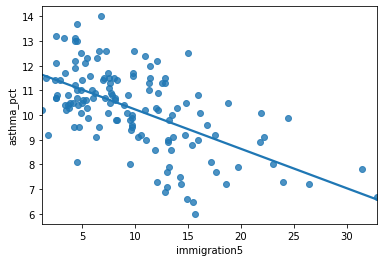

In [258]:
sns.regplot(y = 'asthma_pct', x = 'immigration5', data = asthma_socdem, ci = None);

Describe the relationship between asthma and immigration.

### Fit the regression model

In [259]:
reg_asthmaimm = ols('asthma_pct ~ immigration5', data = asthma_socdem) # setup the model

reg_asthmaimm_fit = regmod.fit() # estimate/fit the model 

### Statistical summary of the regression model

In [260]:
reg_asthmaimm_summ = reg_asthmaimm_fit.summary()

reg_asthmaimm_summ.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8925,0.201,9.432,0.000,1.377,2.408
indvar1,0.5493,0.102,5.411,0.003,0.288,0.810
indvar2,0.3852,0.097,3.984,0.010,0.137,0.634


#  The regression model is the equation:

$$\texttt{asthma_pct} = 11.8266  - 0.1597 \times \texttt{immigration5}$$

- The **slope** indicates that for a 1% **increase** in immigration in the past 5 years the percentage of asthma cases in a neighbourhood **decrease** by 0.1597 (approximately 16%).

- The **y-intercept** indicates that when a neighbourhood has 0% immigration the past 5 years then asthma rates are 11%.  

- Are there any neighbourhoods with 0% immigration in the past 5 years?

In [261]:
asthma_socdem['asthma_pct'].describe()

count    140.000000
mean      10.251429
std        1.647692
min        6.000000
25%        9.200000
50%       10.450000
75%       11.400000
max       14.000000
Name: asthma_pct, dtype: float64

- The **y-intercept** in regression models often doesn't have a sensible interpretation, but is often mathematically important for regression to work well.

## Accuracy of the regression model 

In [262]:
reg_asthmaimm_fit.rsquared

0.991410032226906

Text(0, 0.5, 'residuals')

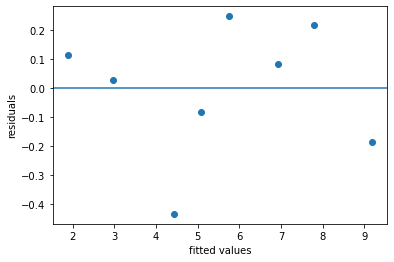

In [263]:
plt.scatter(x = reg_asthmaimm_fit.fittedvalues , y = reg_asthmaimm_fit.resid)
plt.axhline(y = 0)
plt.xlabel('fitted values')
plt.ylabel('residuals')

- The R-squared statistics indicates a very good explanation of the model (close to 1)

- The residuals seem randomly distributed, indicating the model is appropriate.

### Summary

Therefore, we can conclude that the immigration rate in recent 5 years in a neighborhood is negatively associated with the prevalence of asthma in the neighborhood.

Why not causal relationship?

What is the implication?


## Training and testing a model

- Ideally we could assess the accuracy of this linear regression model on a new set of data (i.e., immigration rates in Toronto neighbourhoods in future years.) 

- But, we don't have this data.

- One trick that data scientists use to fit the model on part of the data (training data) and use the remaining part (testing data) to test the accuracy.

- If we only have one data set then the training data can be obtained by randomly selecting rows from the data to fit the regression model, then the remaining rows can be used to test the accuracy of the model.

### Splitting a `pandas` `DataFrame` by `index`

In [265]:
data = {'a' : [1, 2, 3, 4, 5]}

df = pd.DataFrame(data)

df.index

RangeIndex(start=0, stop=5, step=1)

A Boolean array that is `True` if the index is `0` or `1` and `False` otherwise. 

In [266]:
df.index.isin([0,1])

array([ True,  True, False, False, False])

To create a Boolean series that is `False` if the index is `0` or `1` and `True` otherwise we can negate `df.index.isin([0,1])` this Boolean series using the `~` operator `~df.index.isin([0,1])`

In [267]:
~df.index.isin([0,1])

array([False, False,  True,  True,  True])

In [268]:
df[~df.index.isin([0,1])]

,a
2,3
3,4
4,5


### Creating training and test data sets from a single dataset

### Step 1: 

- split the data into a training set with 75% of the rows.

- use the remaining 25% of the data for testing. 

In [269]:
np.random.seed(11) # for reproducibility

# randomly select 75% of neighbourhoods
reg_df_train = asthma_socdem.sample(frac = 0.75, replace = False) 

# get index of training data
train_index = reg_df_train.index

- Exclude indicies from `reg_df_train` using `pandas` `isin` function. 

In [270]:
# exclude rows in training to define test data
reg_df_test = asthma_socdem[~asthma_socdem.index.isin(train_index)]

print(asthma_socdem.shape)

print(reg_df_train.shape)

print(reg_df_test.shape)

(140, 9)
(105, 9)
(35, 9)


### Step 2: Fit the regression model on the training data

In [271]:
reg_train = ols('asthma_pct ~ immigration5', data = reg_df_train) # setup the model

reg_train_fit = reg_train.fit() # estimate/fit the model 

### Step 3: Compute predicted (fitted) values using training data 

In [272]:
# use the model fit on the training data to predict asthma rates
# from the test set. 

predvalues_train = reg_train_fit.predict(reg_df_train['immigration5'])

### Step 4: Evaluate accuracy using root mean-squared error on training data

- Another measure of accuracy of regression models.

- Compares observed values of the dependent variable with the predicted values.

![rmse.jpg](insights_rmse_formula.jpg)



It can be computed using the `rmse` function from `statsmodels`.


In [273]:
# Compute root mean-squared error for the training data.
from statsmodels.tools.eval_measures import rmse

rmse(predvalues_train, reg_df_train['asthma_pct'])


1.3987103239995489

- The observed asthma rates deviate from the predicted asthma rates in each neighbourhood by 1.4% in the training set.

- Is this an acceptable prediction error?

- Let's examine the accuracy of the linear regression model on the test set


### Step 5: Evaluate the accuracy of regression model on the test data using root mean-squared error

- Compute predictions using test data

In [274]:
predvalues_test = reg_train_fit.predict(reg_df_test['immigration5'])


- Now compute the root mean-squared error for the test data using the model fit on the training data.

In [275]:
rmse(predvalues_test, reg_df_test['asthma_pct'])


1.109621980506299

## Conclusion of data analysis using linear regression model

- The regression model appears to provide an accurate fit the data, although both the scatter plot and plot of residuals indicate that there is a lot of variation in asthma rates in neighbourhoods that have between 10% - 20% immigration.

- As the percentage of immigrants to a neighbourhood within the last 5 years increases, the asthma rates will decreases. 

- Regression analyses on aggregated data such as neighbourhoods can be misleading when compared to non-aggregated data.

## Are there other sociaodemographic  factors in our data that might effect asthma rates?

- Let's create a matrix scatter plot using [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) in the `seaborn` library.

- `pairplot` will visualize paired relationship between variables in a dataset.

In [276]:
asthma_socdem.columns

Index(['Neighbid', 'name_x', 'asthma_pct', 'name_y', 'median_income',
       'rented_dwell', 'unemployment', 'immigration5', 'vismin'],
      dtype='object')

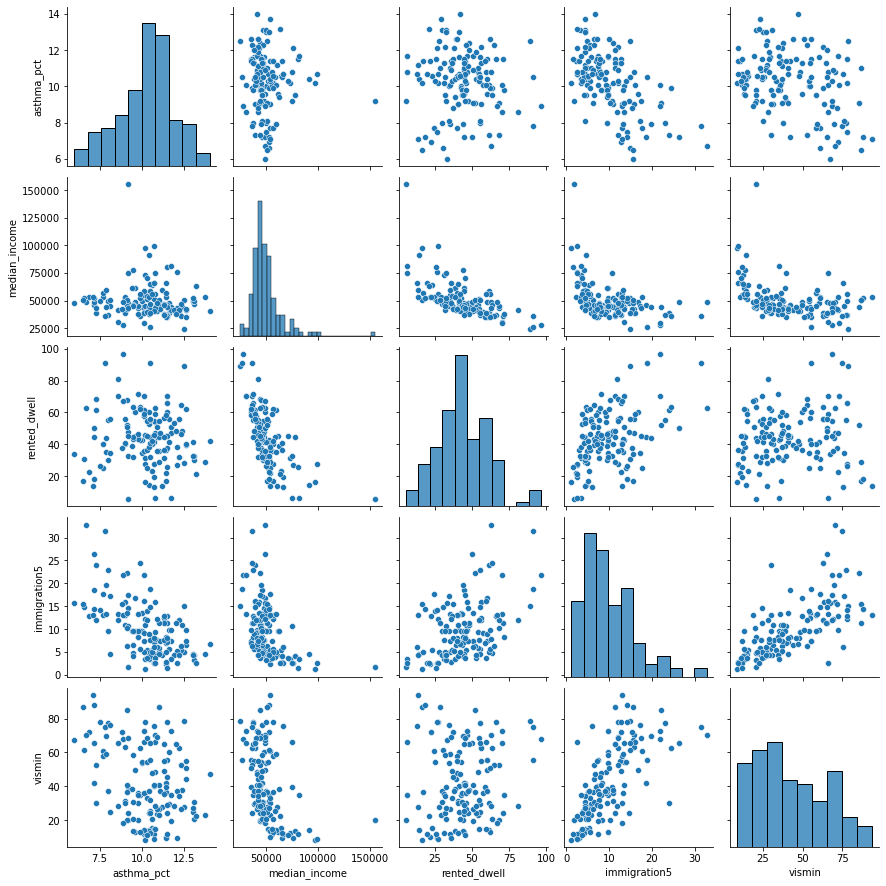

In [277]:
# reduce the column for better presentation
to_show = ['asthma_pct','median_income','rented_dwell','immigration5','vismin']
sns.pairplot(asthma_socdem[to_show]);

- Let's consider median income

- Fit the regression model on all the data and produce a statistical summary.

In [278]:
reg_asthmaimmunem = ols('asthma_pct ~ immigration5 + median_income', data = asthma_socdem) # setup the model

reg_asthmaimmunem_fit = reg_asthmaimmunem.fit() # estimate/fit the model 

reg_asthmaimmunem_summ = reg_asthmaimmunem_fit.summary()

reg_asthmaimmunem_summ.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.3041,0.497,28.758,0.000,13.321,15.288
immigration5,-0.2054,0.019,-10.750,0.000,-0.243,-0.168
median_income,-4.048e-05,7.45e-06,-5.431,0.000,-5.52e-05,-2.57e-05


- Notice that the slope estimate for `median_income` is 0, but so is the p-value and range of plausible values.

- That seems odd.  What's happening?

- We can see from the scatter plot that `immigration5` and `median_income` have a linear relationship.  When two variables have a linear relationship multiple linear regression models produce strange results.

- It's important that independent variables in a multiple regression model are unrelated.

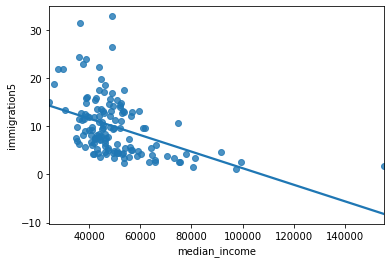

In [279]:
sns.regplot(y = 'immigration5', x = 'median_income', data = asthma_socdem, ci = None);